# ARIMA Model

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
!pip install numpy --upgrade

Requirement already up-to-date: numpy in c:\users\ryanc\anaconda3\lib\site-packages (1.24.4)


In [3]:
!pip install pmdarima --user

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [5]:
# Importing imputed data

USA_train_imputed = pd.read_csv("USA_train_imputed copy.csv")
USA_test_imputed = pd.read_csv("USA_test_imputed copy.csv")
USA_train_imputed.set_index('date', inplace=True)
USA_test_imputed.set_index('date', inplace=True)

Brazil_train_imputed = pd.read_csv("Brazil_train_imputed copy.csv")
Brazil_test_imputed = pd.read_csv("Brazil_test_imputed copy.csv")
Brazil_train_imputed.set_index('date', inplace=True)
Brazil_test_imputed.set_index('date', inplace=True)

Germany_train_imputed = pd.read_csv("Germany_train_imputed copy.csv")
Germany_test_imputed = pd.read_csv("Germany_test_imputed copy.csv")
Germany_train_imputed.set_index('date', inplace=True)
Germany_test_imputed.set_index('date', inplace=True)

Nigeria_train_imputed = pd.read_csv("Nigeria_train_imputed copy.csv")
Nigeria_test_imputed = pd.read_csv("Nigeria_test_imputed copy.csv")
Nigeria_train_imputed.set_index('date', inplace=True)
Nigeria_test_imputed.set_index('date', inplace=True)

China_train_imputed = pd.read_csv("China_train_imputed copy.csv")
China_test_imputed = pd.read_csv("China_test_imputed copy.csv")
China_train_imputed.set_index('date', inplace=True)
China_test_imputed.set_index('date', inplace=True)

Australia_train_imputed = pd.read_csv("Australia_train_imputed copy.csv")
Australia_test_imputed = pd.read_csv("Australia_test_imputed copy.csv")
Australia_train_imputed.set_index('date', inplace=True)
Australia_test_imputed.set_index('date', inplace=True)

In [6]:
import warnings
warnings.filterwarnings("ignore")

# USA model (ARIMA)

In [7]:
# Check to see if data is stationary using ADF test
result = adfuller(USA_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: 0.35350791999422665
p-value: 0.9796705291813941
Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.


In [8]:
# Perform differencing on 'new_cases' column to stationize data
USA_train_imputed['new_cases_diff'] = USA_train_imputed['new_cases'].diff()

# Perform ADF test for stationarity to verify if data is no stationary
result_diff = adfuller(USA_train_imputed['new_cases_diff'].dropna())

# Print the ADF statistic and p-value
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])

# Interpret the results
if result_diff[1] <= 0.05:
    print("Reject the null hypothesis. The differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The differenced series is likely non-stationary.")

ADF Statistic (after differencing): 0.29767238998158063
p-value (after differencing): 0.9772374446883619
Fail to reject the null hypothesis. The differenced series is likely non-stationary.


In [9]:
# Performing second-order differencing on 'new_cases' column to stationze data
USA_train_imputed['new_cases_diff2'] = USA_train_imputed['new_cases'].diff().diff()

# Perform the Augmented Dickey-Fuller test for stationarity on the second-order differenced series
result_diff2 = adfuller(USA_train_imputed['new_cases_diff2'].dropna())

# Print the ADF statistic and p-value
print('ADF Statistic (after second-order differencing):', result_diff2[0])
print('p-value (after second-order differencing):', result_diff2[1])

# Interpret the results
if result_diff2[1] <= 0.05:
    print("Reject the null hypothesis. The second-order differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The second-order differenced series is likely non-stationary.")

ADF Statistic (after second-order differencing): -6.3013091724988115
p-value (after second-order differencing): 3.40678986350552e-08
Reject the null hypothesis. The second-order differenced series is likely stationary.


In [10]:
# Adding 'new_cases_diff2' to the USA_test_imputed data set so we can properly forecast with stationary data
USA_test_imputed['new_cases_diff2'] = USA_test_imputed['new_cases'].diff().diff()

# Deal with NaN values in train dataset
missing_values_train = USA_train_imputed['new_cases_diff2'].isnull()
missing_index_train = USA_train_imputed.index[missing_values_train]
# Fill the missing values for the first two entries with the value from the third entry
USA_train_imputed.loc[missing_index_train, 'new_cases_diff2'] = USA_train_imputed['new_cases_diff2'].iloc[2]

# Deal with NaN values in test dataset
missing_values_test = USA_test_imputed['new_cases_diff2'].isnull()
missing_index_test = USA_test_imputed.index[missing_values_test]
# Fill the missing values for the first two entries with the value from the third entry
USA_test_imputed.loc[missing_index_test, 'new_cases_diff2'] = USA_test_imputed['new_cases_diff2'].iloc[2]

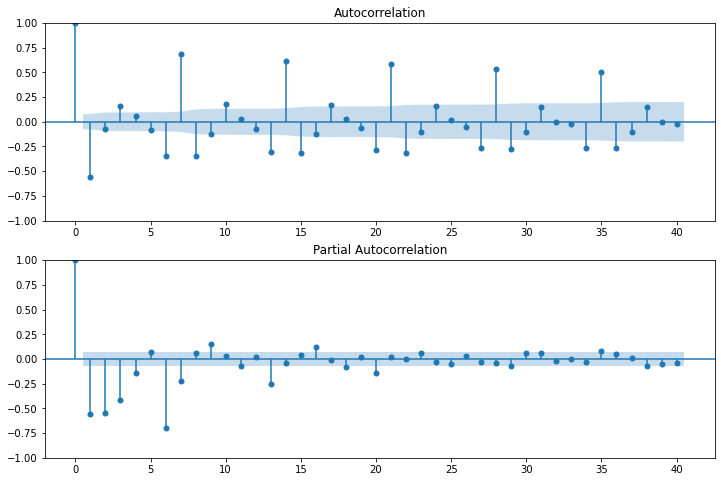

In [11]:
# ACF and PACF plots for 'new_cases_diff2'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(USA_train_imputed['new_cases_diff2'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(USA_train_imputed['new_cases_diff2'], lags=40, ax=ax2)

plt.show()

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer

# Set Randomized Search for optimal hyperparameters for p, d, q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1, 8) for d in range(1, 3) for q in range(1, 8)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search on the stationary 'new_cases_diff2' column
random_search.fit(USA_train_imputed['new_cases_diff2'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (5, 1, 7)}


In [13]:
# Set train and test targets
train_target = USA_train_imputed['new_cases_diff2']
test_target = USA_test_imputed['new_cases_diff2']

# Set up ARIMA model with best hyperparameters
best_order = random_search.best_params_['order']
arima_model = ARIMA(train_target, order=best_order)
arima_model = arima_model.fit()

In [14]:
# Undo the second-order difference on the train predictions
train_pred_diff2 = arima_model.fittedvalues

# Add the cumulative sum of fitted values to the first element of the original 'new_cases' series
train_pred = USA_train_imputed['new_cases'] + train_pred_diff2.cumsum()

# Clip negative values to 0 (as 'new_cases' cannot be negative)
train_pred = train_pred.clip(lower=0)

# Evaluate performance on training data using RMSE in the original scale
train_rmse = np.sqrt(mean_squared_error(USA_train_imputed['new_cases'], train_pred))
print("Train RMSE (Original Scale):", train_rmse)

Train RMSE (Original Scale): 55928.475586458175


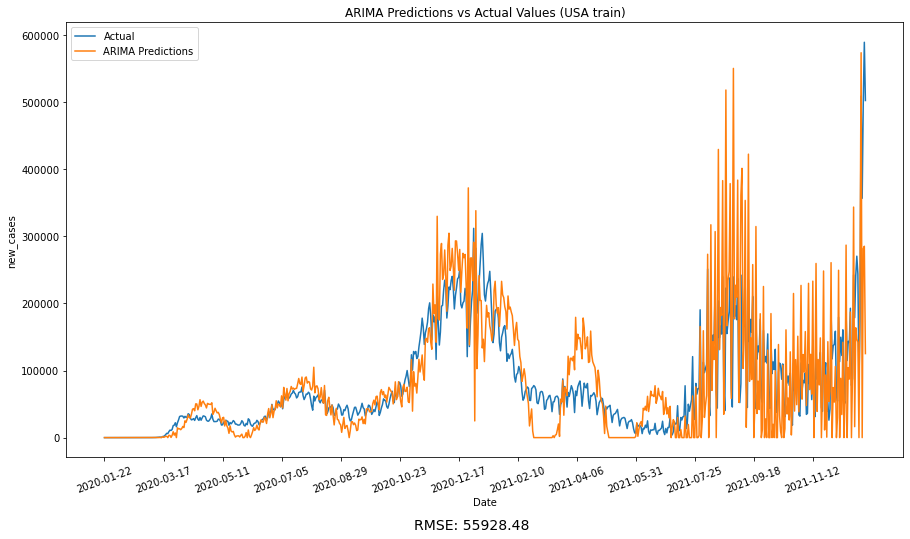

In [15]:
# Create plot visualization
plt.figure(figsize=(15, 8))
plt.plot(USA_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (USA train)')
xticks_indices = np.arange(0, len(USA_train_imputed), 55) # Select every 55th date for display
xticks_labels = USA_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [16]:
# Undo the second-order difference on the test predictions
test_pred_diff2 = arima_model.predict(start=len(train_target), end=len(train_target)+len(test_target)-1, dynamic=True)

# Add the cumulative sum of fitted values to the first element of the original 'new_cases' series
test_pred = USA_test_imputed['new_cases'] + test_pred_diff2.cumsum()

# Clip negative values to 0 (as 'new_cases' cannot be negative)
test_pred = test_pred.clip(lower=0)

# Evaluate performance on training data using RMSE in the original scale
test_rmse = np.sqrt(mean_squared_error(USA_test_imputed['new_cases'], test_pred))
print("Test RMSE (Original Scale):", test_rmse)

Test RMSE (Original Scale): 198791.6408435755


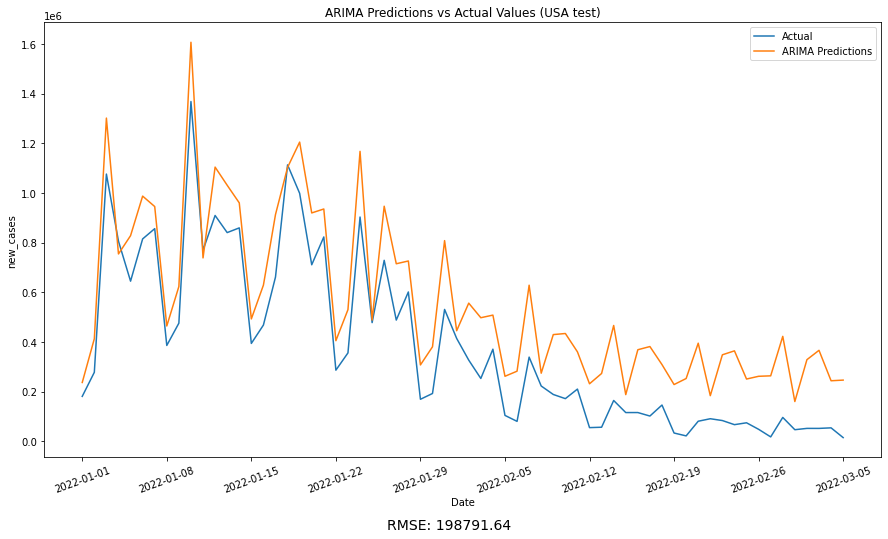

In [17]:
# Create plot visualization
plt.figure(figsize=(15, 8))
plt.plot(USA_test_imputed['new_cases'], label='Actual')
plt.plot(test_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (USA test)')
xticks_indices = np.arange(0, len(USA_test_imputed), 7) # Select every 7th date for display
xticks_labels = USA_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

# Brazil model (ARIMA Univariate)

In [18]:
# Check to see if data is stationary using ADF test
result = adfuller(Brazil_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: -1.345169700624579
p-value: 0.6082623029077228
Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.


In [19]:
# Perform differencing on 'new_cases' column to stationize data
Brazil_train_imputed['new_cases_diff'] = Brazil_train_imputed['new_cases'].diff()

# Perform ADF test for stationarity to verify if data is no stationary
result_diff = adfuller(Brazil_train_imputed['new_cases_diff'].dropna())

# Print the ADF statistic and p-value
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])

# Interpret the results
if result_diff[1] <= 0.05:
    print("Reject the null hypothesis. The differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The differenced series is likely non-stationary.")

ADF Statistic (after differencing): -6.766373556463499
p-value (after differencing): 2.7106281419621723e-09
Reject the null hypothesis. The differenced series is likely stationary.


In [20]:
# Adding 'new_cases_diff' to the Brazil_test_imputed data set so we can properly forecast
Brazil_test_imputed['new_cases_diff'] = Brazil_test_imputed['new_cases'].diff()

# Create 'new_cases_diff' for Brazil_test_imputed
Brazil_test_imputed['new_cases_diff'] = Brazil_test_imputed['new_cases'].diff()

# Deal with NaN values in train_target
missing_values_train = Brazil_train_imputed['new_cases_diff'].isnull()
missing_index_train = Brazil_train_imputed.index[missing_values_train]
# Fill the missing values for the first two entries with the value from the third entry
Brazil_train_imputed.loc[missing_index_train, 'new_cases_diff'] = Brazil_train_imputed['new_cases_diff'].iloc[1]

# Deal with NaN values for the test_target
missing_values_test = Brazil_test_imputed['new_cases_diff'].isnull()
missing_index_test = Brazil_test_imputed.index[missing_values_test]
# Fill the missing values for the first two entries with the value from the third entry
Brazil_test_imputed.loc[missing_index_test, 'new_cases_diff'] = Brazil_test_imputed['new_cases_diff'].iloc[1]

# Set train and test targets
train_target = Brazil_train_imputed['new_cases_diff']
test_target = Brazil_test_imputed['new_cases_diff']

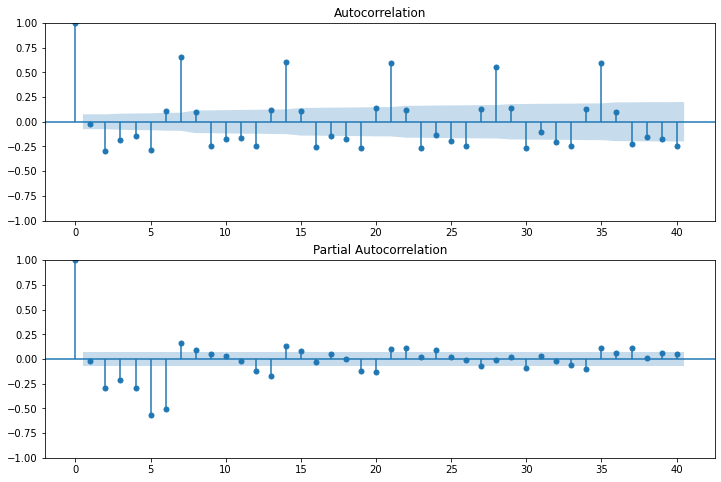

In [21]:
# ACF and PACF plots for 'new_cases_diff'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(Brazil_train_imputed['new_cases_diff'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(Brazil_train_imputed['new_cases_diff'], lags=40, ax=ax2)

plt.show()

In [22]:
# Set Randomized Search for optimal hyperparamters for p,d,q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1,8) for d in range(1,3) for q in range(1,8)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search
random_search.fit(Brazil_train_imputed['new_cases_diff'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (5, 1, 7)}


In [23]:
# Set train and test targets
train_target = Brazil_train_imputed['new_cases_diff']
test_target = Brazil_test_imputed['new_cases_diff']

# Set up ARIMA model with best hyperparameters
best_order = random_search.best_params_['order']
arima_model = ARIMA(train_target, order=best_order)
arima_model = arima_model.fit()

In [24]:
# Undo the second-order difference on the training predictions
train_pred_diff = arima_model.fittedvalues

# Add the cumulative sum of fitted values to the first element of the original 'new_cases' series
train_pred = Brazil_train_imputed['new_cases'] + train_pred_diff.cumsum()

# Clip negative values to 0 (as 'new_cases' cannot be negative)
train_pred = train_pred.clip(lower=0)

# Evaluate performance on training data using RMSE in the original scale
train_rmse = np.sqrt(mean_squared_error(Brazil_train_imputed['new_cases'], train_pred))
print("Training RMSE (Original Scale):", train_rmse)

Training RMSE (Original Scale): 51229.194020035495


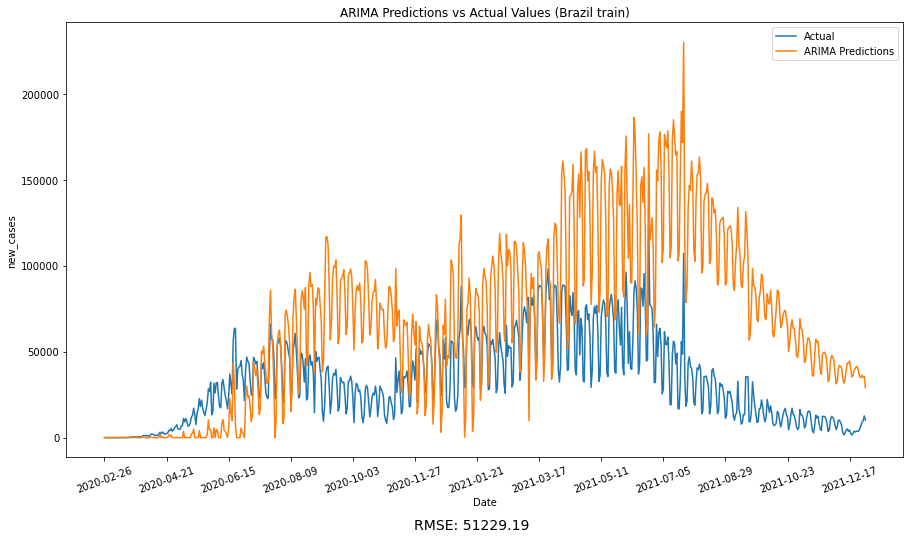

In [25]:
# Create plot visualization
plt.figure(figsize=(15, 8))
plt.plot(Brazil_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Brazil train)')
xticks_indices = np.arange(0, len(Brazil_train_imputed), 55) # Select every 55th date for display
xticks_labels = Brazil_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [26]:
# Undo the second-order difference on the test predictions
test_pred_diff2 = arima_model.predict(start=len(train_target), end=len(train_target)+len(test_target)-1, dynamic=True)

# Add the cumulative sum of fitted values to the first element of the original 'new_cases' series
test_pred = USA_test_imputed['new_cases'] + test_pred_diff2.cumsum()

# Clip negative values to 0 (as 'new_cases' cannot be negative)
test_pred = test_pred.clip(lower=0)

# Evaluate performance on test data using RMSE in the original scale
test_rmse = np.sqrt(mean_squared_error(USA_test_imputed['new_cases'], test_pred))
print("Test RMSE (Original Scale):", test_rmse)

Test RMSE (Original Scale): 3415.0040562827066


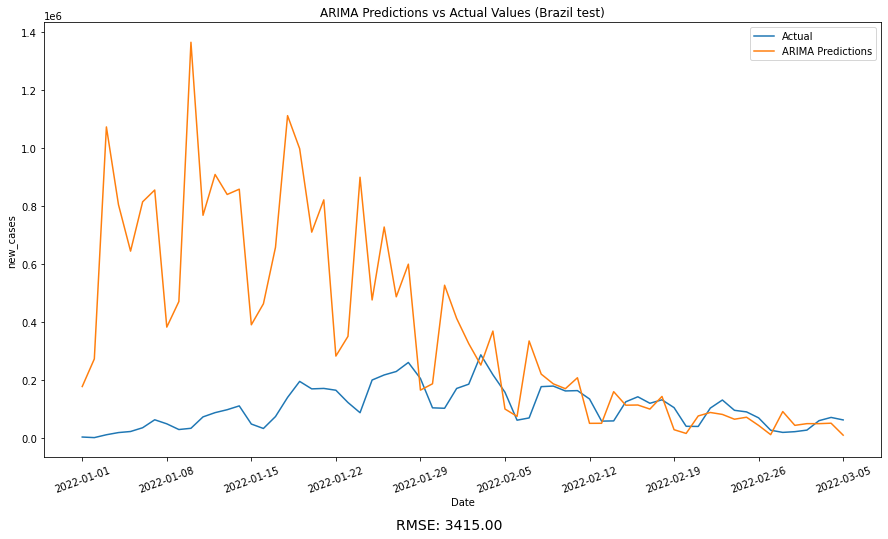

In [27]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(Brazil_test_imputed.index, Brazil_test_imputed['new_cases'], label='Actual')

# Plot ARIMA predictions
plt.plot(Brazil_test_imputed.index, test_pred, label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Brazil test)')
xticks_indices = np.arange(0, len(Brazil_test_imputed), 7) # Select every 7th date for display
xticks_labels = Brazil_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

# Germany model (ARIMA Univariate)

In [28]:
# Check to see if data is stationary using ADF test
result = adfuller(Germany_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: -3.0337856122622346
p-value: 0.03185745763244454
Reject the null hypothesis. The 'new_cases' time series is likely stationary.


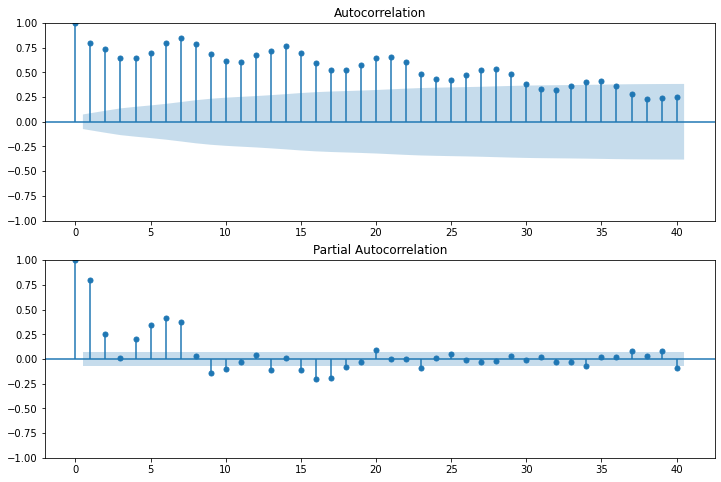

In [29]:
# ACF and PACF plots for 'new_cases_diff2'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(Germany_train_imputed['new_cases'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(Germany_train_imputed['new_cases'], lags=40, ax=ax2)

plt.show()

In [30]:
# Set Randomized Search for optimal hyperparameters for p,d,q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1,8) for d in range(0,3) for q in range(1,8)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search
random_search.fit(Germany_train_imputed['new_cases'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (6, 2, 7)}


In [31]:
# Extract the best hyperparameters
best_order = random_search.best_params_['order']

# Train the final ARIMA model with the best hyperparameters
model = ARIMA(Germany_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on the training set
train_pred = fit_model.fittedvalues  # Using fittedvalues for in-sample predictions

# Evaluate the model performance on the training set using RMSE
train_rmse = np.sqrt(mean_squared_error(Germany_train_imputed['new_cases'], train_pred))
print("Training RMSE:", train_rmse)

Training RMSE: 5983.585264796352


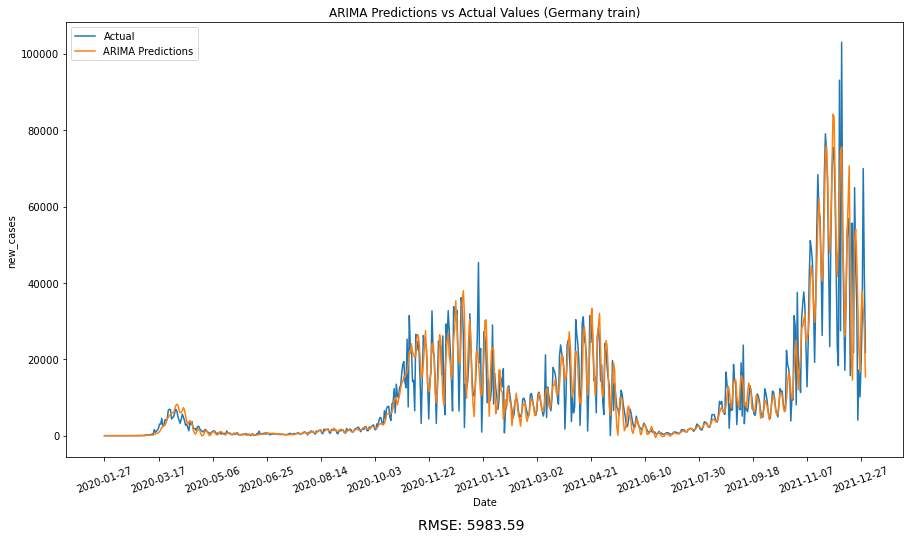

In [32]:
# Plot visualization
plt.figure(figsize=(15, 8))
plt.plot(Germany_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Germany train)')
xticks_indices = np.arange(0, len(Germany_train_imputed), 50) # Select every 50th date for display
xticks_labels = Germany_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [33]:
# Fit ARIMA model on training data
best_order = random_search.best_params_['order']
model = ARIMA(Germany_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on test data
test_pred = fit_model.forecast(steps=len(Germany_test_imputed))

# Evaluate performance on test data (using RMSE as an example)
test_rmse = np.sqrt(mean_squared_error(Germany_test_imputed['new_cases'], test_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 167724.5272628095


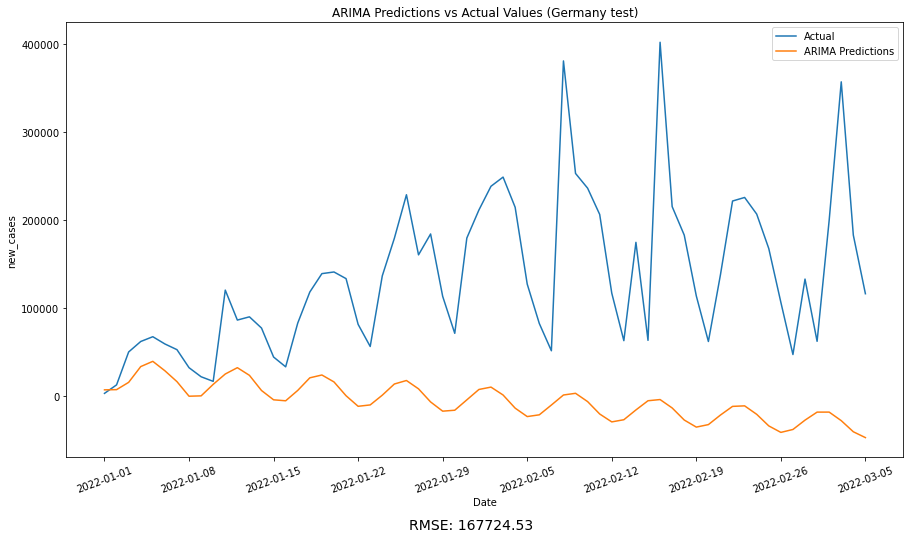

In [34]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(Germany_test_imputed.index, Germany_test_imputed['new_cases'], label='Actual')

# Plot ARIMA predictions
plt.plot(Germany_test_imputed.index, test_pred, label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Germany test)')
xticks_indices = np.arange(0, len(Germany_test_imputed), 7) # Select every 7th date for display
xticks_labels = Germany_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

# China model (ARIMA Univariate)

In [35]:
# Check to see if data is stationary using ADF test
result = adfuller(China_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: -7.5297590149143385
p-value: 3.604559833670165e-11
Reject the null hypothesis. The 'new_cases' time series is likely stationary.


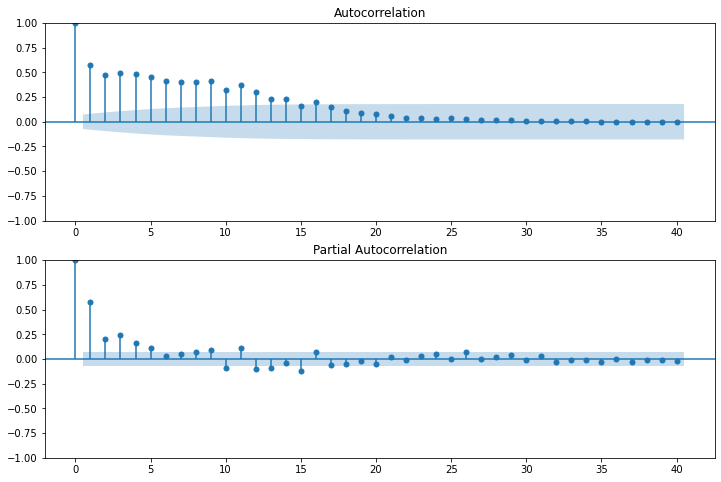

In [36]:
# ACF and PACF plots for 'new_cases_diff2'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(China_train_imputed['new_cases'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(China_train_imputed['new_cases'], lags=40, ax=ax2)

plt.show()

In [37]:
# Set Randomized Search for optimal hyperparameters for p,d,q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1,4) for d in range(0,3) for q in range(1,8)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search
random_search.fit(China_train_imputed['new_cases'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (3, 2, 6)}


In [38]:
# Extract the best hyperparameters
best_order = random_search.best_params_['order']

# Train the final ARIMA model with the best hyperparameters
model = ARIMA(China_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on the training set
train_pred = fit_model.fittedvalues  # Using fittedvalues for in-sample predictions

# Evaluate the model performance on the training set using RMSE
train_rmse = np.sqrt(mean_squared_error(China_train_imputed['new_cases'], train_pred))
print("Training RMSE:", train_rmse)

Training RMSE: 628.9586962945707


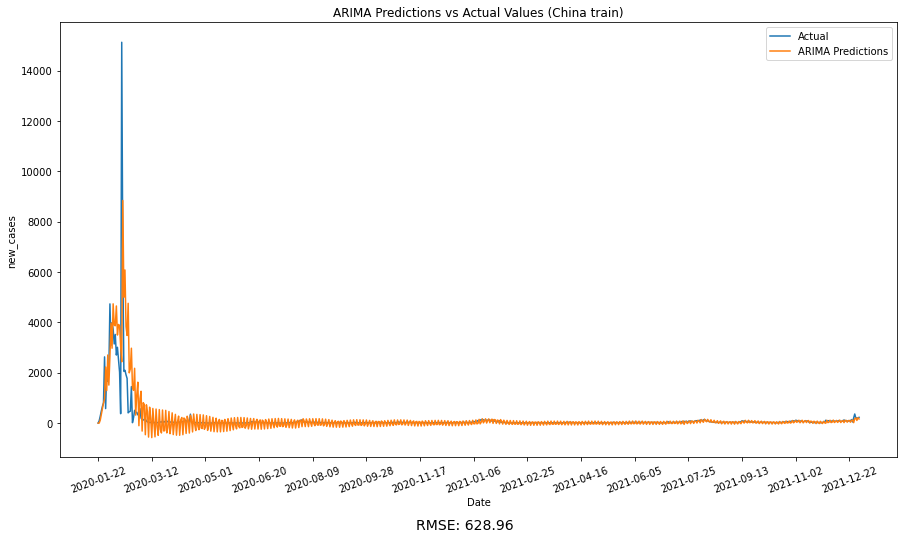

In [39]:
# Plot visualization
plt.figure(figsize=(15, 8))
plt.plot(China_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (China train)')
xticks_indices = np.arange(0, len(China_train_imputed), 50) # Select every 50th date for display
xticks_labels = China_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [40]:
# Fit ARIMA model on training data
best_order = random_search.best_params_['order']
model = ARIMA(China_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on test data
test_pred = fit_model.forecast(steps=len(China_test_imputed))

# Evaluate performance on test data (using RMSE as an example)
test_rmse = np.sqrt(mean_squared_error(China_test_imputed['new_cases'], test_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 85.95161715349387


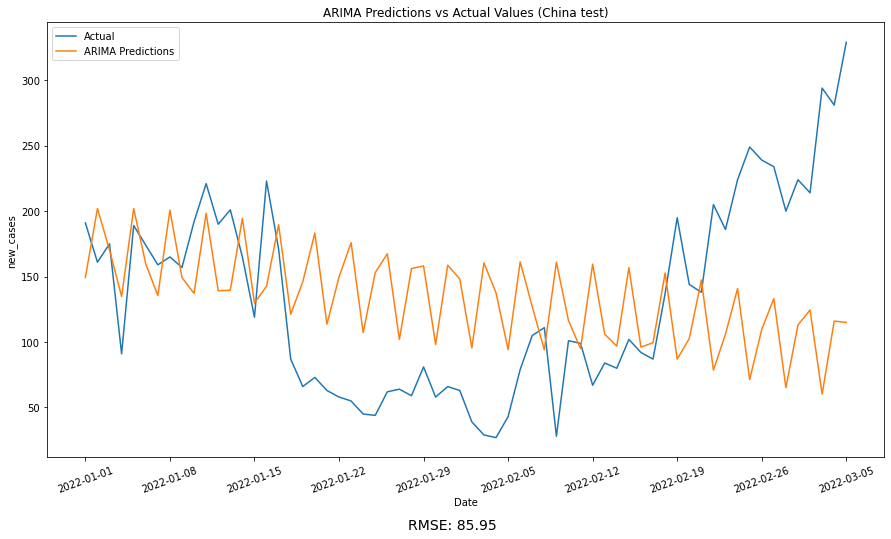

In [41]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(China_test_imputed.index, China_test_imputed['new_cases'], label='Actual')

# Plot ARIMA predictions
plt.plot(China_test_imputed.index, test_pred, label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (China test)')
xticks_indices = np.arange(0, len(China_test_imputed), 7) # Select every 7th date for display
xticks_labels = China_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

# Nigeria model (ARIMA Univariate)

In [42]:
# Check to see if data is stationary using ADF test
result = adfuller(Nigeria_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: -2.9077023883038535
p-value: 0.04445961806463605
Reject the null hypothesis. The 'new_cases' time series is likely stationary.


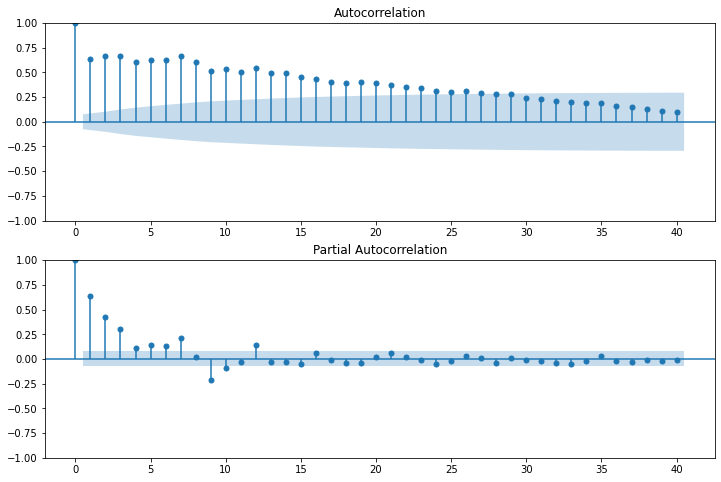

In [43]:
# ACF and PACF plots for 'new_cases_diff2'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(Nigeria_train_imputed['new_cases'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(Nigeria_train_imputed['new_cases'], lags=40, ax=ax2)

plt.show()

In [44]:
# Set Randomized Search for optimal hyperparameters for p,d,q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1,4) for d in range(0,3) for q in range(1,8)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search
random_search.fit(Nigeria_train_imputed['new_cases'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (3, 2, 6)}


In [45]:
# Extract the best hyperparameters
best_order = random_search.best_params_['order']

# Train the final ARIMA model with the best hyperparameters
model = ARIMA(Nigeria_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on the training set
train_pred = fit_model.fittedvalues  # Using fittedvalues for in-sample predictions

# Evaluate the model performance on the training set using RMSE
train_rmse = np.sqrt(mean_squared_error(Nigeria_train_imputed['new_cases'], train_pred))
print("Training RMSE:", train_rmse)

Training RMSE: 285.85427645847466


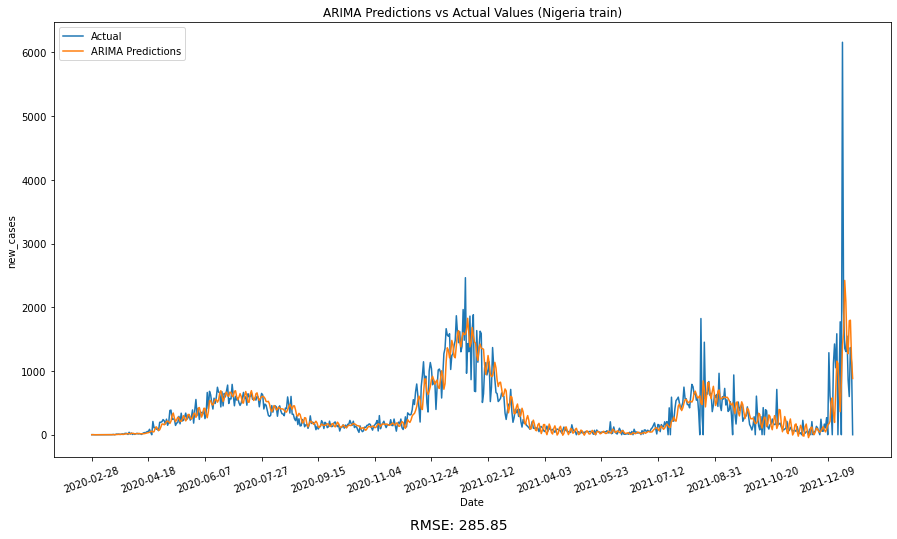

In [46]:
# Plot visualization
plt.figure(figsize=(15, 8))
plt.plot(Nigeria_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Nigeria train)')
xticks_indices = np.arange(0, len(Nigeria_train_imputed), 50) # Select every 50th date for display
xticks_labels = Nigeria_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [47]:
# Fit ARIMA model on training data
best_order = random_search.best_params_['order']
model = ARIMA(China_train_imputed['new_cases'], order=best_order)
fit_model = model.fit()

# Make predictions on test data
test_pred = fit_model.forecast(steps=len(China_test_imputed))

# Evaluate performance on test data (using RMSE as an example)
test_rmse = np.sqrt(mean_squared_error(China_test_imputed['new_cases'], test_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 85.95161715349387


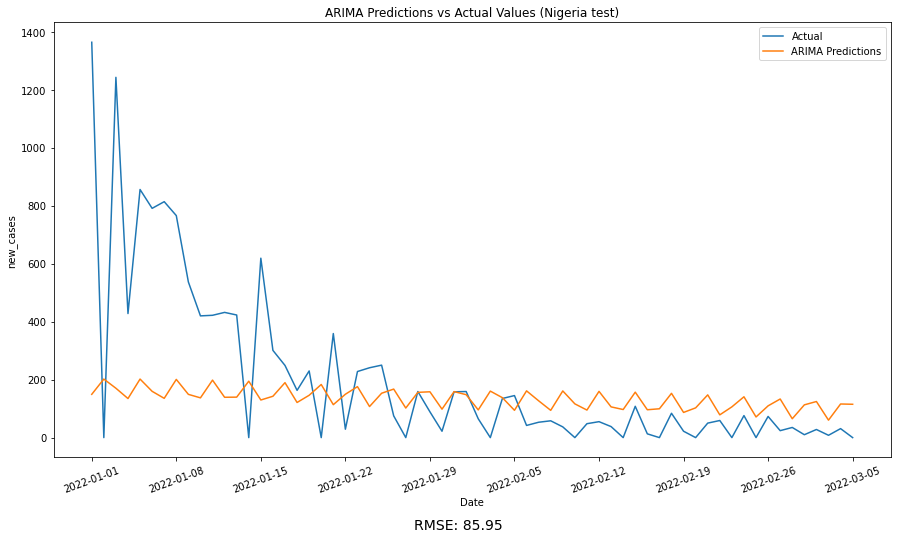

In [48]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(Nigeria_test_imputed.index, Nigeria_test_imputed['new_cases'], label='Actual')

# Plot ARIMA predictions
plt.plot(Nigeria_test_imputed.index, test_pred, label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Nigeria test)')
xticks_indices = np.arange(0, len(Nigeria_test_imputed), 7) # Select every 7th date for display
xticks_labels = Nigeria_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

# Australia model (ARIMA Univariate)

In [49]:
# Check to see if data is stationary using ADF test
result = adfuller(Australia_train_imputed['new_cases'])

# Print the ADF statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The 'new_cases' time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.")

ADF Statistic: 0.32767689462414884
p-value: 0.9785792556801214
Fail to reject the null hypothesis. The 'new_cases' time series is likely non-stationary.


In [50]:
# Perform first-order differencing to stationize data
Australia_train_imputed['new_cases_diff'] = Australia_train_imputed['new_cases'].diff()

# Perform the Augmented Dickey-Fuller test for stationarity on the first-order differenced series
result_diff = adfuller(Australia_train_imputed['new_cases_diff'].dropna())

# Print the ADF statistic and p-value
print('ADF Statistic (after first-order differencing):', result_diff[0])
print('p-value (after first-order differencing):', result_diff[1])

# Interpret the results
if result_diff[1] <= 0.05:
    print("Reject the null hypothesis. The first-order differenced series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The first-order differenced series is likely non-stationary.")

ADF Statistic (after first-order differencing): 7.846110524475045
p-value (after first-order differencing): 1.0
Fail to reject the null hypothesis. The first-order differenced series is likely non-stationary.


Since the differencing method made this worse, trying a log transformation below instead.

In [51]:
# Since first-order differencing made the ADF statistic higher, we will opt for a different transformation. 
# Instead trying a log transform while also adding a small constant since a log transformation is not defined for zero or negative values. 
small_constant = 1e-10
Australia_train_imputed['new_cases_log'] = np.log(Australia_train_imputed['new_cases'] + small_constant)

# Perform the Augmented Dickey-Fuller test for stationarity on the log-transformed series
result_log = adfuller(Australia_train_imputed['new_cases_log'])

# Print the ADF statistic and p-value
print('ADF Statistic (after log transformation):', result_log[0])
print('p-value (after log transformation):', result_log[1])

# Interpret the results
if result_log[1] <= 0.05:
    print("Reject the null hypothesis. The log-transformed series is likely stationary.")
else:
    print("Fail to reject the null hypothesis. The log-transformed series is likely non-stationary.")

ADF Statistic (after log transformation): -6.76685604217936
p-value (after log transformation): 2.7033969063111766e-09
Reject the null hypothesis. The log-transformed series is likely stationary.


In [52]:
# Adding 'new_cases_log' to the Australia_test_imputed data set so we can properly forecast
small_constant = 1e-10
Australia_test_imputed['new_cases_log'] = np.log(Australia_test_imputed['new_cases'] + small_constant)

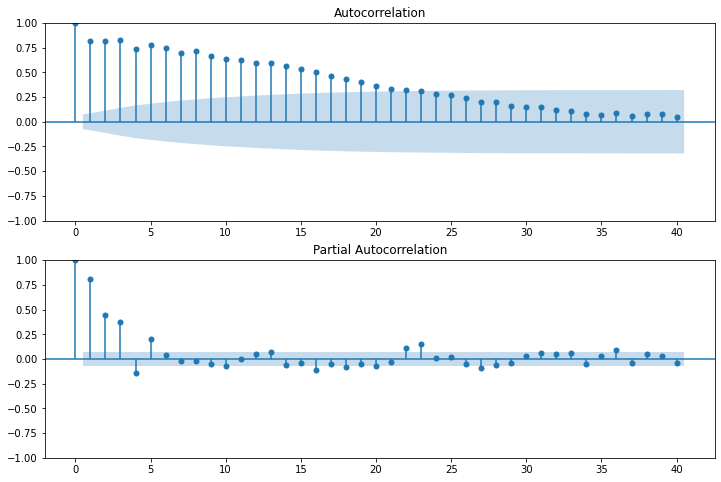

In [53]:
# ACF and PACF plots for 'new_cases_log'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(Australia_train_imputed['new_cases_log'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(Australia_train_imputed['new_cases_log'], lags=40, ax=ax2)

plt.show()

In [54]:
# Set Randomized Search for optimal hyperparamters for p,d,q values
class ARIMAWrapper(BaseEstimator):
    def __init__(self, order=(0, 0, 0)):
        self.order = order

    def fit(self, X, y=None):
        self.model = ARIMA(X, order=self.order)
        self.fit_model = self.model.fit()
        return self

    def predict(self, X):
        return self.fit_model.forecast(steps=len(X))

# Define the hyperparameter space
param_dist = {
    'order': [(p, d, q) for p in range(1,5) for d in range(1,3) for q in range(1,15)],
}

# Create ARIMAWrapper model
arima_wrapper = ARIMAWrapper()

# Create a scorer based on negative mean squared error
scorer = make_scorer(lambda y, y_pred: -mean_squared_error(y, arima_wrapper.fit(y).predict(y)), greater_is_better=True)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=arima_wrapper,
    param_distributions=param_dist,
    n_iter=10,
    scoring=scorer,
    cv=5,
    random_state=42
)

# Perform the search
random_search.fit(Australia_train_imputed['new_cases_log'])

# Print the best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

Best Hyperparameters:  {'order': (2, 1, 13)}


In [55]:
# Set train and test targets
train_target = Australia_train_imputed['new_cases_log']
test_target = Australia_test_imputed['new_cases_log']

# Set up ARIMA model with best hyperparameters
best_order = random_search.best_params_['order']
arima_model = ARIMA(train_target, order=best_order)
arima_model = arima_model.fit()

In [56]:
# Undo the second-order difference on the training predictions
train_pred_log = arima_model.fittedvalues

# Apply the inverse operation (exponential) to get back to the original scale
train_pred = np.exp(train_pred_log)

# Clip negative values to 0 (as 'new_cases' cannot be negative)
train_pred = train_pred.clip(lower=0)

# Evaluate performance on train data using RMSE in the original scale
train_rmse = np.sqrt(mean_squared_error(Australia_train_imputed['new_cases'], train_pred))
print("Train RMSE (Original Scale):", train_rmse)

Train RMSE (Original Scale): 9347.43447524754


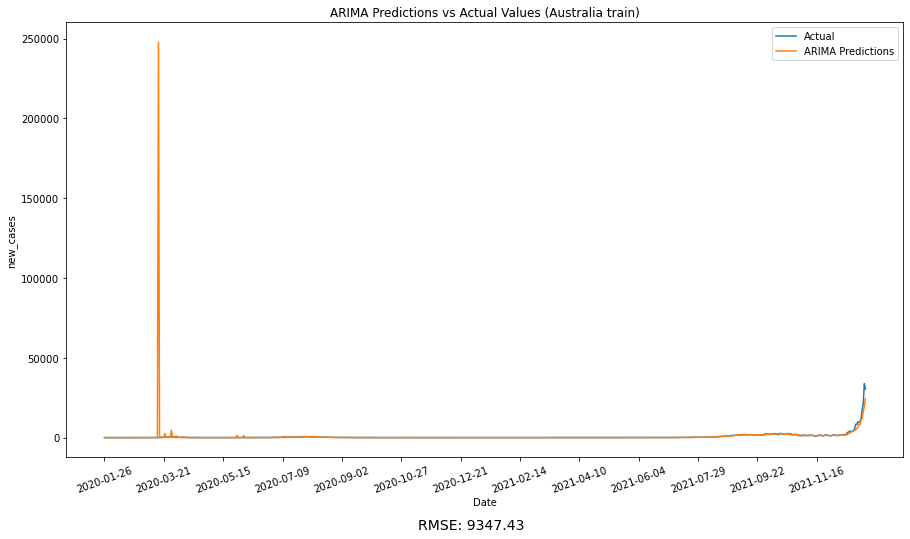

In [57]:
# Create plot visualization
plt.figure(figsize=(15, 8))
plt.plot(Australia_train_imputed['new_cases'], label='Actual')
plt.plot(train_pred, label='ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Australia train)')
xticks_indices = np.arange(0, len(Australia_train_imputed), 55) # Select every 55th date for display
xticks_labels = Australia_train_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {train_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()

In [58]:
# Undo the second-order difference on the test predictions
test_pred_log = arima_model.predict(start=len(train_target), end=len(train_target)+len(test_target)-1, dynamic=True)

# Add the cumulative sum of fitted values to the first element of the original 'new_cases' series
test_pred = np.exp(test_pred_log)

# Clip negative values to 0 (as 'new_cases' cannot be negative)
test_pred = test_pred.clip(lower=0)

# Evaluate performance on test data using RMSE in the original scale
test_rmse = np.sqrt(mean_squared_error(Australia_test_imputed['new_cases'], test_pred))
print("Test RMSE (Original Scale):", test_rmse)

Test RMSE (Original Scale): 34025.93041305406


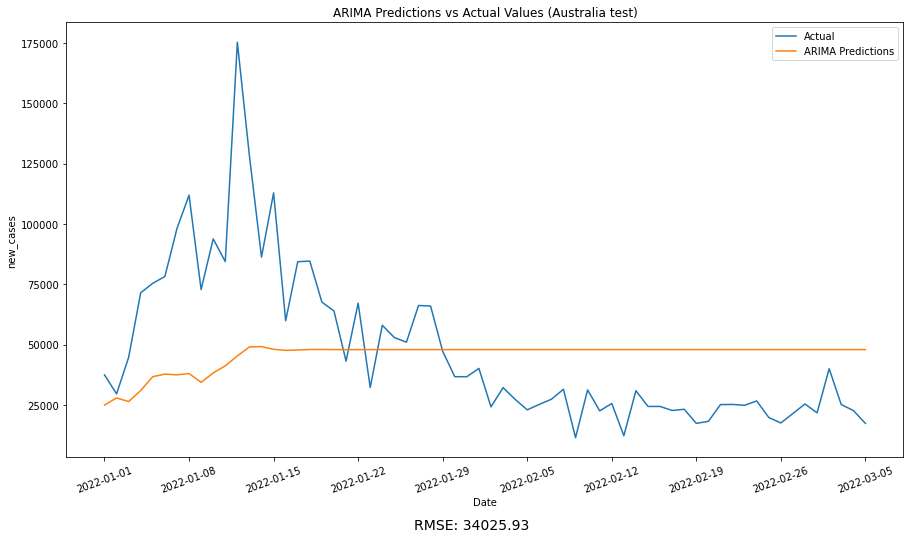

In [59]:
# Set the figure size
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(Australia_test_imputed.index, Australia_test_imputed['new_cases'], label='Actual')

# Plot ARIMA predictions
plt.plot(Australia_test_imputed.index, test_pred, label='ARIMA Predictions')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('new_cases')
plt.title('ARIMA Predictions vs Actual Values (Australia test)')
xticks_indices = np.arange(0, len(Australia_test_imputed), 7) # Select every 7th date for display
xticks_labels = Australia_test_imputed.index[xticks_indices]
plt.xticks(xticks_indices, xticks_labels, rotation=20)
plt.legend()
rmse_text = f'RMSE: {test_rmse:.2f}'
plt.figtext(0.5, 0.001, rmse_text, wrap=True, horizontalalignment='center', fontsize=14)
plt.show()